# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, average_precision_score, precision_score, recall_score, roc_auc_score
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
import seaborn as sns

import sys
sys.path.insert(0, '../src/')
from evaluation.plot_confusion_matrix import plot_confusion_matrix
from preprocessing.pre_ml_process import pre_ml_process, pre_ml_process_no_resample, pre_ml_process_resample_PolyFeatures

# Import Data

In [2]:
df_raw = pd.read_csv("../../data/dataset.csv", encoding="cp1252")

# Data Cleaning

In [3]:
df = df_raw.dropna()
df = df.loc[df["f7"] != "#"]
df["f7"] = df["f7"].astype(float)

# f9
# remove the unknown record and binary encode the remaining two classes
df = df.loc[df["f9"] != "unknown"]
df = df.reset_index(drop=True)

le_f9 = LabelEncoder()
df["f9"] = le_f9.fit_transform(df["f9"])

numerical_cols = df.dtypes[df.dtypes != object].index.tolist()
df_num = df[numerical_cols]
df_num = df_num.drop("employee_id", axis=1)

# Preprocessing & Modelling

In [4]:
def output_metrics(clf, X, y, metric, printing=True, returning=True):
    if metric == average_precision_score:
        y_hat = clf.predict_proba(X)[:,1]
    else:
        y_hat = clf.predict(X)
    score = metric(y, y_hat)
    if printing:
        print(score)
    if returning:
        return score
    
    
def evaluate_model(clf, X_train_resample_scaled, X_test_scaled, y_train, y_test, df_in, scaler, ros, poly_transformer,
                   printing=True):
    # Get predictions
    y_hat_train = clf.predict(X_train_resample_scaled)
    y_hat_test = clf.predict(X_test_scaled)
    y_proba_test = clf.predict_proba(X_test_scaled)[:,1]


    # Confusion Matrix
    df_cm = confusion_matrix(y_test, y_hat_test, labels=[1, 0])
    
    if printing:
        plot_confusion_matrix(df_cm, 
                          target_names=[1, 0], 
                          title="%s Confusion Matrix" % (type(clf).__name__),
                          normalize=True)
    # accuracy metrics
    ap = average_precision_score(y_test, y_proba_test)
    ps = precision_score(y_test, y_hat_test)
    rs = recall_score(y_test, y_hat_test)
    roc = roc_auc_score(y_test, y_hat_test)
    
    output_d = {}
    output_d["clf"] = clf
    output_d["X_train_resample_scaled"] = X_train_resample_scaled
    output_d["X_test_scaled"] = X_test_scaled
    output_d["y_train"] = y_train
    output_d["y_test"] = y_test
    output_d["y_hat_train"] = y_hat_train
    output_d["y_hat_test"] = y_hat_test
    output_d["y_proba_test"] = y_proba_test
    output_d["df_cm"] = df_cm
    output_d["ap"] = ap
    output_d["ps"] = ps
    output_d["rs"] = rs
    output_d["roc"] = roc
    output_d["scaler"] = scaler
    output_d["poly_transformer"] = poly_transformer
    
    if printing:
        print("average_precision_score = {:.3f}".format(ap))
        print("precision_score = {:.3f}".format(ps))
        print("recall_score = {:.3f}".format(rs))
        print("roc_auc_score = {:.3f}".format(roc))
    
    if type(clf).__name__ == "RandomForestClassifier" or type(clf).__name__ == "XGBClassifier":
        df_feature_importances = pd.DataFrame(clf.feature_importances_, columns=["Importance"])
        col_names = df_in.columns.tolist()
        col_names.remove("has_left")
        df_feature_importances["Feature_names"] = col_names
        df_feature_importances.sort_values("Importance", ascending=False, inplace=True)
        df_feature_importances = df_feature_importances.round(4)
        output_d["df_feature_importances"] = df_feature_importances

        if printing:
            print(df_feature_importances)
    
    return output_d #[y_hat_train, y_hat_test, y_proba_test, df_cm, ap, ps, rs, roc]

In [5]:
def preprocess_train_eval(df_in, 
                          LRC=LogisticRegression(solver="lbfgs", random_state=0), 
                          RFC=RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=0), 
                          
                          XG_params = {"random_state":0}, 
                          xgb_fit_eval_metric="aucpr",

                          printing=False, printing_ap=False, returning=True, split_random_state=42,
                          printing_rs=False,

                         train_test_split_random_state=42,
                         RandomOverSampler_random_state=42,
                         test_size=0.33,
                         preprocessing_function=pre_ml_process
                         ):
    
    df_in, X, y, X_train, X_test, y_train, y_test, \
                scaler, X_train_resample_scaled, y_train_resample, \
                X_test_scaled, ros, poly_transformer = \
                preprocessing_function(df_in, 
                               test_size,
                               train_test_split_random_state,
                               RandomOverSampler_random_state)

    outputs = {}
    
    # Train with Logistic Regression
    if LRC != None:
        clf_LR = LRC.fit(X_train_resample_scaled, y_train_resample)
        outputs_LR = evaluate_model(clf_LR, X_train_resample_scaled, X_test_scaled, y_train, y_test, 
                                    df_in, scaler, ros, poly_transformer, printing)
        if printing_ap:
            print("LR ap = {:.3f}".format(outputs_LR["ap"]))
        if printing_rs:
            print("LR rs = {:.3f}".format(outputs_LR["rs"]))
        outputs["LR"] = outputs_LR
    
    # Train with Random Forest Classifier
    if RFC != None:
        clf_RF = RFC.fit(X_train_resample_scaled, y_train_resample)
        outputs_RF = evaluate_model(clf_RF, X_train_resample_scaled, X_test_scaled, y_train, y_test, 
                                    df_in, scaler, ros, poly_transformer, printing)
        if printing_ap:
            print("RF ap = {:.3f}".format(outputs_RF["ap"]))
        if printing_rs:
            print("RF rs = {:.3f}".format(outputs_RF["rs"]))
        outputs["RF"] = outputs_RF

    
    # Train with XGBoost Classifier
    if XG_params != None:
        clf_XG = xgb.XGBClassifier()
        clf_XG.set_params(**XG_params)
        
        clf_XG.fit(X_train_resample_scaled, y_train_resample, eval_metric=xgb_fit_eval_metric)
        outputs_XG = evaluate_model(clf_XG, X_train_resample_scaled, X_test_scaled, y_train, y_test, 
                                    df_in, scaler, ros, poly_transformer, printing)
        if printing_ap:
            print("XG ap = {:.3f}".format(outputs_XG["ap"]))
        if printing_rs:
            print("XG rs = {:.3f}".format(outputs_XG["rs"]))
        outputs["XG"] = outputs_XG   
    
    if returning:
        return outputs


## Baseline

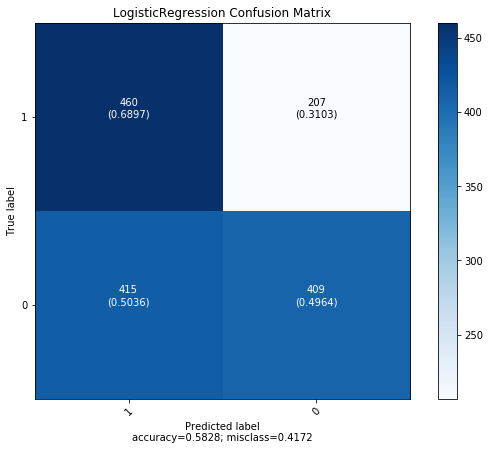

average_precision_score = 0.592
precision_score = 0.526
recall_score = 0.690
roc_auc_score = 0.593


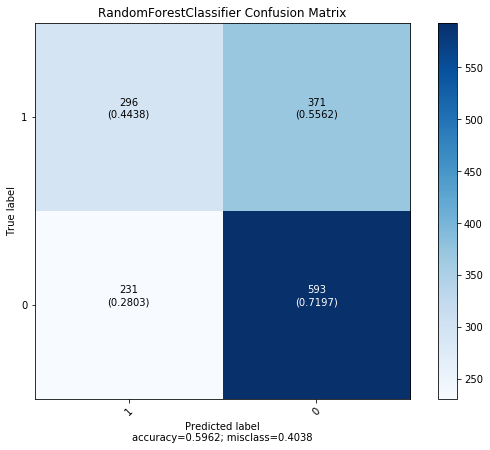

average_precision_score = 0.565
precision_score = 0.562
recall_score = 0.444
roc_auc_score = 0.582
   Importance Feature_names
6      0.3738           f13
3      0.2375            f8
0      0.1332            f5
2      0.1224            f7
1      0.0821            f6
4      0.0354            f9
5      0.0155           f11


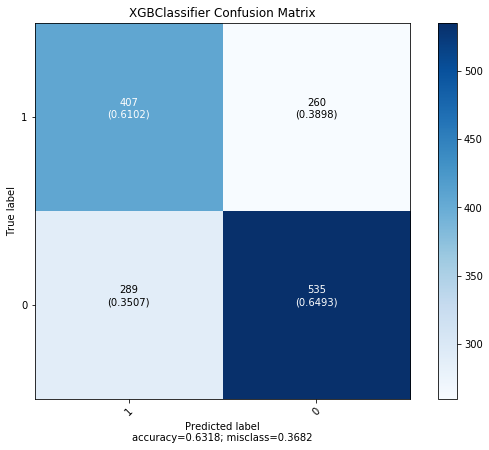

average_precision_score = 0.633
precision_score = 0.585
recall_score = 0.610
roc_auc_score = 0.630
   Importance Feature_names
6      0.2443           f13
3      0.2232            f8
2      0.1845            f7
0      0.1634            f5
1      0.1318            f6
4      0.0281            f9
5      0.0246           f11


In [6]:
# BASELINE: Isolate the numeric variables
clf_baseline_LR, clf_baseline_RF, clf_baseline_XG = preprocess_train_eval(df_num, printing=True)

## Feature Engineering

### One hot encoding

In [7]:
def add_one_hot_encoded(df_baseline, df_to_ohe, col):
    df_ohe = pd.get_dummies(df_to_ohe[col], columns=col)
    df_out = df_baseline.join(df_ohe)
    return df_out

In [8]:
# f1 only
df_num_f1 = add_one_hot_encoded(df_num, df, ["f1"])
preprocess_train_eval(df_num_f1, printing_ap=True, returning=False)

LR ap = 0.687
RF ap = 0.678
XG ap = 0.718


In [9]:
df_num_f1_f3 = add_one_hot_encoded(df_num_f1, df, "f3")
preprocess_train_eval(df_num_f1_f3, printing_ap=True, returning=False)

LR ap = 0.702
RF ap = 0.703
XG ap = 0.726


In [10]:
df_num_f1_f3_f10 = add_one_hot_encoded(df_num_f1_f3, df, "f10")
preprocess_train_eval(df_num_f1_f3_f10, printing_ap=True, returning=False)

LR ap = 0.703
RF ap = 0.704
XG ap = 0.726


In [11]:
df_num_f1_f3_f10_f12 = add_one_hot_encoded(df_num, df, ["f1", "f3", "f10", "f12"])
preprocess_train_eval(df_num_f1_f3_f10_f12, printing_ap=True, returning=False)

LR ap = 0.706
RF ap = 0.706
XG ap = 0.736


In [12]:
df_num_f1_f3_f10_f12 = add_one_hot_encoded(df_num, df, ["f1", "f3", "f10", "f12"])
preprocess_train_eval(df_num_f1_f3_f10_f12, printing_ap=True, returning=False)

LR ap = 0.706
RF ap = 0.706
XG ap = 0.736


### label encoding

In [13]:
def fit_label_encoders(df_in):
    fitted_label_encoders = {}
    for col in df_in.dtypes[df_in.dtypes == object].index.tolist():
        fitted_label_encoders[col] = LabelEncoder().fit(df_in[col])
    return fitted_label_encoders

def add_label_encoded(df_baseline, df_to_le, cols, fitted_label_encoders):
    df_out = df_baseline.copy()
    for col in cols:
        df_le = fitted_label_encoders[col].transform(df_to_le[col])
        df_out[col] = df_le
    return df_out

fitted_label_encoders = fit_label_encoders(df.drop("employee_id", axis=1))

df_num_allLE = add_label_encoded(df_num, df, ["f1", "f2", "f3", "f4", "f10", "f12"], fitted_label_encoders)

op_allLE = preprocess_train_eval(df_num_allLE, printing_ap=True)

LR ap = 0.582
RF ap = 0.764
XG ap = 0.784


#### Recursive Feature Elimination

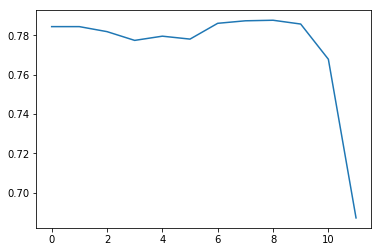

In [14]:
# recursive feature elimination
feature_elim_col_name = []
feature_elim_outputs_XG = []

allLE_XG = op_allLE["XG"]

for col in allLE_XG["df_feature_importances"].sort_values("Importance", ascending=True)["Feature_names"]:
    if len(feature_elim_col_name) < len(allLE_XG["df_feature_importances"]) - 1:
        feature_elim_col_name.append(col)
    
        fe_XG = preprocess_train_eval(df_num_allLE.drop(feature_elim_col_name, axis=1), printing=False, printing_ap=False)["XG"]
        feature_elim_outputs_XG.append(fe_XG["ap"])
    
plt.plot([x for x in range(len(feature_elim_col_name))], feature_elim_outputs_XG)
plt.show()

No real difference as features with the lowest importance are eliminated

#### Polynomial features

In [15]:
from sklearn.preprocessing import PolynomialFeatures

# Make a new dataframe for polynomial features
input_poly_features_list = ['f5', 'f6', 'f7', 'f8', 'f11', 'f13']
poly_features = df[input_poly_features_list]

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Fit and transform the poly_transformer to the data
poly_features = poly_transformer.fit_transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

# Create a dataframe of the features 
poly_features_corr = pd.DataFrame(
    poly_features, 
    columns = poly_transformer.get_feature_names(input_features = input_poly_features_list)
)

# Add in the target
poly_features_corr['has_left'] = df["has_left"].copy()

# Find the correlations with the target
poly_corrs = poly_features_corr.corr()['has_left'].sort_values()

# Display most correlated to TARGET
poly_corrs_df = pd.concat([poly_corrs, abs(poly_corrs)], axis=1).reset_index()
poly_corrs_df.columns = ["Var", "Corr", "Abs_Corr"]
poly_corrs_df.sort_values(by="Abs_Corr", ascending=False, inplace=True)
poly_corrs_df.reset_index(inplace=True, drop=True)
print("Most correlated engineered features to TARGET:")
poly_corrs_df.drop(0)

Polynomial Features shape:  (4518, 84)
Most correlated engineered features to TARGET:


,Var,Corr,Abs_Corr
1,f8,-0.205664,0.205664
2,f7 f8,-0.201009,0.201009
3,f7,-0.199160,0.199160
4,f5 f7 f8,-0.195625,0.195625
5,f7 f8 f13,-0.191540,0.191540
6,f7 f8^2,-0.189113,0.189113
7,f5 f7,-0.188540,0.188540
8,f8^2,-0.187338,0.187338
9,f7 f13,-0.187224,0.187224
10,f5 f7 f13,-0.176779,0.176779


In [16]:
print("No resampling:")
preprocess_train_eval(
    df_num_allLE, 
    printing=False, printing_ap=True, printing_rs=True, returning=False,
    preprocessing_function=pre_ml_process_no_resample)

print("\nResampling:")
preprocess_train_eval(
    df_num_allLE, 
    printing=False, printing_ap=True, printing_rs=True, returning=False)

print("\nResampling and Polynomial Features")
preprocess_train_eval(
    df_num_allLE, 
    printing=False, printing_ap=True, printing_rs=True, returning=False,
    preprocessing_function=pre_ml_process_resample_PolyFeatures)

No resampling:
LR ap = 0.585
LR rs = 0.355
RF ap = 0.774
RF rs = 0.559
XG ap = 0.788
XG rs = 0.532

Resampling:
LR ap = 0.582
LR rs = 0.678
RF ap = 0.764
RF rs = 0.603
XG ap = 0.784
XG rs = 0.684

Resampling and Polynomial Features
LR ap = 0.586
LR rs = 0.643
RF ap = 0.634
RF rs = 0.550
XG ap = 0.772
XG rs = 0.690


#### Hyperparameter Tuning

In [17]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time

df_ignore, X, y, X_train, X_test, y_train, y_test, \
        scaler, X_train_resample_scaled, y_train_resample, \
        X_test_scaled, ros, poly = pre_ml_process(df_num_allLE, 
                                                  train_test_split_random_state=0, 
                                                  RandomOverSampler_random_state=0)

    
param_grid = {
        'max_depth': [3, 6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

# param_grid = {
#         'silent': [True],
#         'max_depth': [3, 6, ],
#         'n_estimators': [100]}

clf=xgb.XGBClassifier()

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=100,
                            n_jobs=1, verbose=0, cv=5,
#                             scoring='neg_log_loss', 
                            refit=True, random_state=42)


print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(X_train_resample_scaled, y_train_resample, eval_metric='aucpr')
print("Randomized search time:", time.time() - search_time_start, "\n")

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Randomized search time: 122.50211262702942 

Best score: 0.8025114155251142
Best params: 
colsample_bylevel: 0.9
colsample_bytree: 1.0
gamma: 0.25
learning_rate: 0.2
max_depth: 10
min_child_weight: 0.5
n_estimators: 100
reg_lambda: 0.1
subsample: 0.9


In [18]:
op_allLE["XG"]["clf"].get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [19]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time

df_ignore, X, y, X_train, X_test, y_train, y_test, \
        scaler, X_train_resample_scaled, y_train_resample, \
        X_test_scaled, ros, poly = pre_ml_process(df_num_allLE, 
                                                  train_test_split_random_state=0, 
                                                  RandomOverSampler_random_state=0)

clf_best_rs = xgb.XGBClassifier()
clf_best_rs.set_params(**best_params)
clf_best_rs.fit(X_train_resample_scaled, y_train_resample, eval_metric='aucpr')

metrics = [average_precision_score, recall_score, precision_score, roc_auc_score]
metric_names = ["average_precision_score", "recall_score", "precision_score", "roc_auc_score"]

for metric, m_name in zip(metrics, metric_names):
    orig = output_metrics(op_allLE["XG"]["clf"], X_test_scaled, y_test, metric, printing=False)
    rsbest = output_metrics(clf_best_rs, X_test_scaled, y_test, metric, printing=False)
    print("{}:\n\tDefault Hyper Params: {}\n\tRandSer Hyper Params: {}".format(m_name, orig, rsbest))

average_precision_score:
	Default Hyper Params: 0.811149658792298
	RandSer Hyper Params: 0.7846121859733777
recall_score:
	Default Hyper Params: 0.6749611197511665
	RandSer Hyper Params: 0.6516329704510109
precision_score:
	Default Hyper Params: 0.7368421052631579
	RandSer Hyper Params: 0.7065767284991569
roc_auc_score:
	Default Hyper Params: 0.746089050441621
	RandSer Hyper Params: 0.7232221456028639


The default hyper parameters out performed a randomised hyper parameter search when the trained algorithms were evaluated on the test set. This is likely due to the best random search model overfitting its training data

#### Increasing n_estimators

In [20]:
df_ignore, X, y, X_train, X_test, y_train, y_test, \
        scaler, X_train_resample_scaled, y_train_resample, \
        X_test_scaled, ros, poly = pre_ml_process(df_num_allLE, 
                                                  train_test_split_random_state=0, 
                                                  RandomOverSampler_random_state=0)

clf_XG_10000 = xgb.XGBClassifier(random_state=0, n_estimators=1000)

clf_XG_10000.fit(X_train_resample_scaled, y_train_resample, eval_metric='aucpr')

metrics = [average_precision_score, recall_score, precision_score, roc_auc_score]
metric_names = ["average_precision_score", "recall_score", "precision_score", "roc_auc_score"]

for metric, m_name in zip(metrics, metric_names):
    orig = output_metrics(op_allLE["XG"]["clf"], X_test_scaled, y_test, metric, printing=False)
    rsbest = output_metrics(clf_XG_10000, X_test_scaled, y_test, metric, printing=False)
    print("{}:\n\tDefault Hyper Params: {}\n\tRandSer Hyper Params: {}".format(m_name, orig, rsbest))

average_precision_score:
	Default Hyper Params: 0.811149658792298
	RandSer Hyper Params: 0.8336194904347973
recall_score:
	Default Hyper Params: 0.6749611197511665
	RandSer Hyper Params: 0.6920684292379471
precision_score:
	Default Hyper Params: 0.7368421052631579
	RandSer Hyper Params: 0.7355371900826446
roc_auc_score:
	Default Hyper Params: 0.746089050441621
	RandSer Hyper Params: 0.7516945919774641


Increasing the number of estimators improves model performance

In [21]:
# FE
df_ignore, X, y, X_train, X_test, y_train, y_test, \
        scaler, X_train_resample_scaled, y_train_resample, \
        X_test_scaled, ros, poly = pre_ml_process(df_num_allLE, 
                                                  train_test_split_random_state=0, 
                                                  RandomOverSampler_random_state=0)

clf_XG_10000 = xgb.XGBClassifier(random_state=0, n_estimators=1000)

clf_XG_10000.fit(X_train_resample_scaled, y_train_resample, eval_metric='aucpr')

metrics = [average_precision_score, recall_score, precision_score, roc_auc_score]
metric_names = ["average_precision_score", "recall_score", "precision_score", "roc_auc_score"]

for metric, m_name in zip(metrics, metric_names):
    orig = output_metrics(op_allLE["XG"]["clf"], X_test_scaled, y_test, metric, printing=False)
    rsbest = output_metrics(clf_XG_10000, X_test_scaled, y_test, metric, printing=False)
    print("{}:\n\tDefault Hyper Params: {}\n\tRandSer Hyper Params: {}".format(m_name, orig, rsbest))

average_precision_score:
	Default Hyper Params: 0.811149658792298
	RandSer Hyper Params: 0.8336194904347973
recall_score:
	Default Hyper Params: 0.6749611197511665
	RandSer Hyper Params: 0.6920684292379471
precision_score:
	Default Hyper Params: 0.7368421052631579
	RandSer Hyper Params: 0.7355371900826446
roc_auc_score:
	Default Hyper Params: 0.746089050441621
	RandSer Hyper Params: 0.7516945919774641


In [23]:
df_feature_importances = pd.DataFrame(clf_XG_10000.feature_importances_, columns=["Importance"])
col_names = df_num_allLE.columns.tolist()
col_names.remove("has_left")
df_feature_importances["Feature"] = col_names
df_feature_importances.sort_values("Importance", ascending=False, inplace=True)
df_feature_importances = df_feature_importances.round(4)
df_feature_importances.reset_index(drop=True)

,Importance,Feature
0,0.1805,f13
1,0.1619,f2
2,0.1485,f8
3,0.1065,f7
4,0.0970,f4
5,0.0920,f1
6,0.0628,f6
7,0.0482,f5
8,0.0304,f12
9,0.0277,f3


#### Subtracting features

In [24]:
df_num_allLE_subtr = df_num_allLE.copy()
num_cols = ['f5', 'f6', 'f7', 'f8', 'f13']
for i in num_cols:
    for j in num_cols:
        if i!=j:
            df_num_allLE_subtr["{}-{}".format(i, j)] = df_num_allLE[i] - df_num_allLE[j]

df_ignore, X, y, X_train, X_test, y_train, y_test, \
        scaler, X_train_resample_scaled, y_train_resample, \
        X_test_scaled, ros, poly = pre_ml_process(df_num_allLE_subtr, 
                                                  train_test_split_random_state=0, 
                                                  RandomOverSampler_random_state=0)

clf_XG_10000 = xgb.XGBClassifier(random_state=0, n_estimators=10000)

clf_XG_10000.fit(X_train_resample_scaled, y_train_resample, eval_metric='aucpr')

metrics = [average_precision_score, recall_score, precision_score, roc_auc_score]
metric_names = ["average_precision_score", "recall_score", "precision_score", "roc_auc_score"]

for metric, m_name in zip(metrics, metric_names):
    rsbest = output_metrics(clf_XG_10000, X_test_scaled, y_test, metric, printing=False)
    print("{}:\n\t{}\n".format(m_name, rsbest))

average_precision_score:
	0.7491484983569943

recall_score:
	0.6360808709175739

precision_score:
	0.6650406504065041

roc_auc_score:
	0.6965781713078435



## PCA Dimensionality Reduction

### PCA f2

In [26]:
cols = "f2"
df_f2_ohe = pd.get_dummies(df[cols])
pca_f2 = PCA(n_components=10).fit(df_f2_ohe)
df_f2_pca = pd.DataFrame(pca_f2.transform(df_f2_ohe))
df_num_f2 = df_num.reset_index(drop=True).join(df_f2_pca)

preprocess_train_eval(df_num_f2, returning=False, printing_ap=True)

LR ap = 0.625
RF ap = 0.718
XG ap = 0.753


### PCA f2 and join to ohe'd others

In [27]:
cols = "f2"
df_f2_ohe = pd.get_dummies(df[cols])
pca_f2 = PCA(n_components=10).fit(df_f2_ohe)
df_f2_pca = pd.DataFrame(pca_f2.transform(df_f2_ohe))
df_num_f2 = df_num.reset_index(drop=True).join(df_f2_pca)

df_num_f1_f3_f10_f12_PCAf2 = add_one_hot_encoded(df_num_f2, df.reset_index(drop=True), ["f1", "f3", "f10", "f12"])

preprocess_train_eval(df_num_f1_f3_f10_f12_PCAf2, returning=False, printing_ap=True)

C:\Users\Kieron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LR ap = 0.716
RF ap = 0.804
XG ap = 0.796


### PCA all categoricals

C:\Users\Kieron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Kieron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Kieron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Kieron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Kieron\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Conve

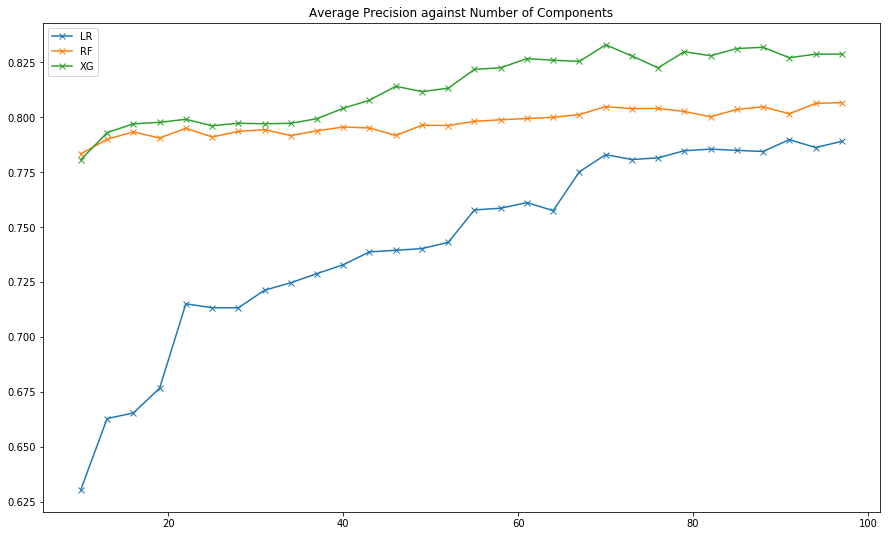

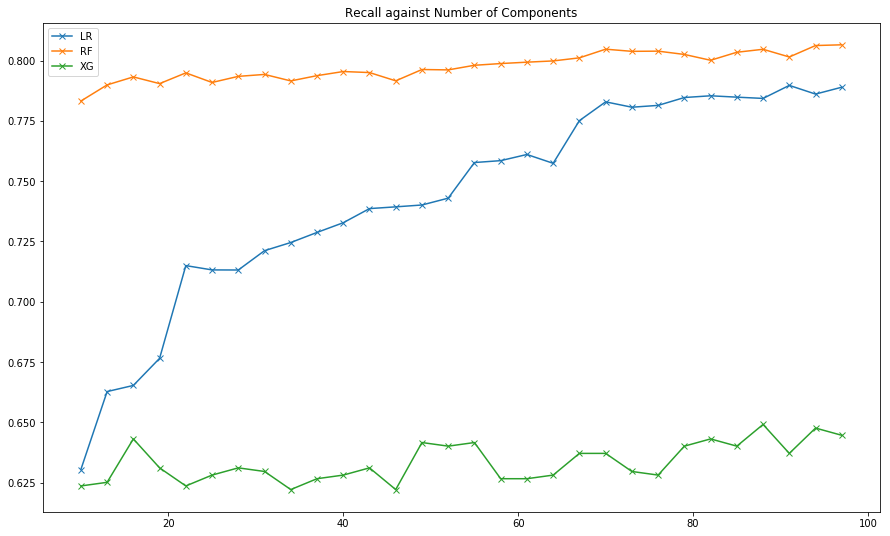

In [40]:
cols = ["f1", "f2", "f3", "f10", "f12"]
df_all_ohe = pd.get_dummies(df[cols])

n_components_list = []
ap_LR_list = []
ap_RF_list = []
ap_XG_list = []

rs_LR_list = []
rs_RF_list = []
rs_XG_list = []

for i in range(10, 100, 3):

    pca_all = PCA(n_components=i).fit(df_all_ohe)
    df_allPCA = pd.DataFrame(pca_all.transform(df_all_ohe))
    df_num_allPCA = df_num.reset_index(drop=True).join(df_allPCA)

    output_PCA_x = preprocess_train_eval(df_num_allPCA, printing=False, printing_ap=False,
                                                                       returning=True)
    
    n_components_list.append(i)
    ap_LR_list.append(output_PCA_x["LR"]["ap"])
    ap_RF_list.append(output_PCA_x["RF"]["ap"])
    ap_XG_list.append(output_PCA_x["XG"]["ap"])
    
    rs_LR_list.append(output_PCA_x["LR"]["ap"])
    rs_RF_list.append(output_PCA_x["RF"]["ap"])
    rs_XG_list.append(output_PCA_x["RF"]["rs"])
    
plt.figure(figsize=(15, 9))
plt.plot(n_components_list, ap_LR_list, "x-", label="LR")
plt.plot(n_components_list, ap_RF_list, "x-", label="RF")
plt.plot(n_components_list, ap_XG_list, "x-", label="XG")
plt.legend(loc="best")
plt.title("Average Precision against Number of Components")
plt.show()

plt.figure(figsize=(15, 9))
plt.plot(n_components_list, rs_LR_list, "x-", label="LR")
plt.plot(n_components_list, rs_RF_list, "x-", label="RF")
plt.plot(n_components_list, rs_XG_list, "x-", label="XG")
plt.legend(loc="best")
plt.title("Recall against Number of Components")
plt.show()

60 components is where the gain in average precision levels off for the three algorithms.

The recall score for XGBoost is not overally affected by increasing components (and similar for random forest) but again 60 components is around when Linear Regression begins to level off in gained recall.

In [41]:
cols = ["f1", "f2", "f3", "f10", "f12"]
df_all_ohe = pd.get_dummies(df[cols])


pca_all = PCA(n_components=60).fit(df_all_ohe)
df_allPCA = pd.DataFrame(pca_all.transform(df_all_ohe))
df_num_allPCA = df_num.reset_index(drop=True).join(df_allPCA)


op_allPCA = preprocess_train_eval(df_num_allPCA, printing=False, printing_ap=True)

LR ap = 0.762
RF ap = 0.799
XG ap = 0.825
